In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df, capability_calculation
from utilities_plotting import plot_scatter, plot_capability, plot_simple_limits, plot_to_pdf
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value=None, placeholder='Type the fiber label or left blank for all', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider_x = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='X-axis mean')
mean_slider_y = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.005, readout_format='.3f', description='Y-axis mean')
range_slider_x = widgets.IntSlider(value=5, min=1, max=10, step=1, description='X-axis zoom')
range_slider_y = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
try:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_filtered_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_corrected_")[-1]
except:
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_limits")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits), description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1), layout=Layout(width='600px'), options=('VA_007_fixture_da…

Table *VA_007_measurements_2024y_01m_09d_15h_53m_55s* retrieved succesfully.
Table *VA_007_limits_2024y_01m_09d_15h_53m_55s* retrieved succesfully.


In [4]:
##Data creation
try:
    MEAS.columns = [f"Test: {int(col)+1}" for col in MEAS.columns]  # str
except ValueError:
    MEAS = MEAS.rename(columns={i: f"Test: {i+1}" for i in range(MEAS.shape[1])})  # int
try:
    LIMITS.columns = ["LO_LIMIT", "HI_LIMIT"]  # str
except ValueError:
    LIMITS = LIMITS.rename(columns={LIMITS.columns[0]: "LO_LIMIT", LIMITS.columns[1]: "HI_LIMIT"})  # int
DATA_format = rename_index(pd.concat([MEAS, LIMITS], axis=1))
display(DATA_format)


,Test: 1,Test: 2,Test: 3,Test: 4,Test: 5,Test: 6,Test: 7,Test: 8,Test: 9,Test: 10,...,Test: 23,Test: 24,Test: 25,Test: 26,Test: 27,Test: 28,Test: 29,Test: 30,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.3288,0.3273,0.3270,0.3278,0.3271,0.3268,0.3270,0.3276,0.3269,0.3267,...,0.3277,0.3272,0.3281,0.3272,0.3278,0.3282,0.3273,0.3273,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.3505,0.3497,0.3494,0.3501,0.3496,0.3492,0.3492,0.3500,0.3492,0.3493,...,0.3500,0.3498,0.3504,0.3497,0.3502,0.3503,0.3497,0.3498,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.3295,0.3293,0.3290,0.3302,0.3293,0.3282,0.3286,0.3294,0.3283,0.3284,...,0.3286,0.3291,0.3295,0.3291,0.3295,0.3294,0.3289,0.3290,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.3510,0.3506,0.3504,0.3514,0.3506,0.3499,0.3502,0.3508,0.3500,0.3500,...,0.3502,0.3506,0.3509,0.3505,0.3509,0.3508,0.3504,0.3505,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.3243,0.3238,0.3237,0.3237,0.3238,0.3237,0.3235,0.3242,0.3236,0.3238,...,0.3224,0.3241,0.3240,0.3240,0.3241,0.3240,0.3238,0.3240,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.3458,0.3450,0.3449,0.3448,0.3450,0.3449,0.3448,0.3453,0.3449,0.3450,...,0.3440,0.3453,0.3452,0.3452,0.3452,0.3452,0.3450,0.3452,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.3284,0.3282,0.3282,0.3283,0.3280,0.3287,0.3285,0.3284,0.3277,0.3283,...,0.3290,0.3292,0.3291,0.3292,0.3290,0.3290,0.3289,0.3293,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.3512,0.3512,0.3512,0.3512,0.3510,0.3516,0.3514,0.3513,0.3507,0.3512,...,0.3519,0.3520,0.3520,0.3519,0.3519,0.3517,0.3517,0.3521,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.3282,0.3287,0.3282,0.3282,0.3280,0.3283,0.3283,0.3284,0.3275,0.3280,...,0.3291,0.3297,0.3292,0.3293,0.3291,0.3290,0.3289,0.3293,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.3511,0.3515,0.3512,0.3512,0.3511,0.3513,0.3514,0.3514,0.3503,0.3508,...,0.3520,0.3524,0.3520,0.3521,0.3519,0.3518,0.3519,0.3520,0.325,0.358


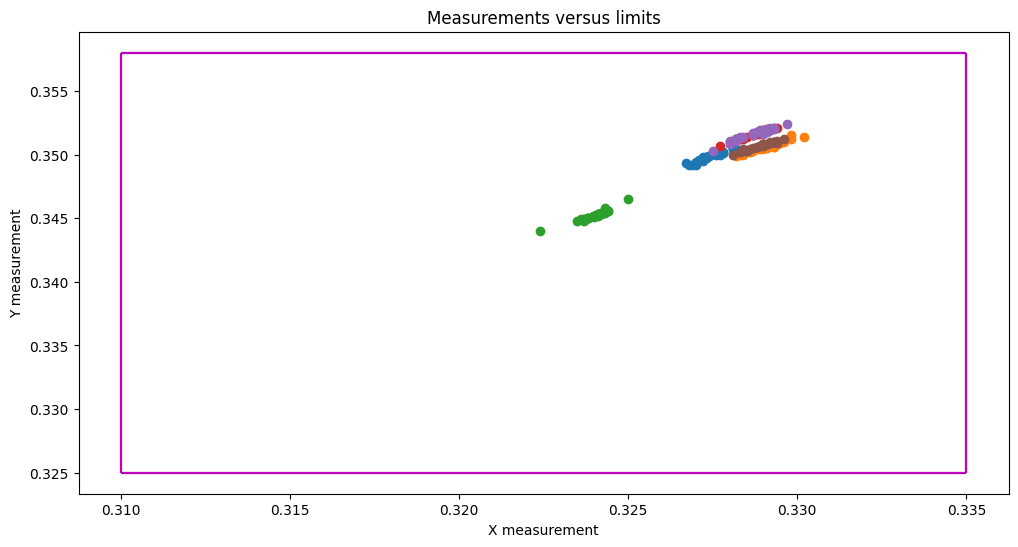

In [5]:
##Data visualization
label = fiber_selection.value
if auto_position.value is False:
    range_mapping = [0.05 - 0.0049 * (range_slider_x.value)]
    xrange = [mean_slider_x.value - range_mapping[0], mean_slider_x.value + range_mapping[0]]
    yrange = [mean_slider_y.value - range_mapping[0], mean_slider_y.value + range_mapping[0]]
else:
    range_mapping = None; xrange = None; yrange = None
display(HBox([fiber_selection, auto_position, mean_slider_x, mean_slider_y]))
display(HBox([range_slider_x, range_slider_y]))
_ = plot_simple_limits(DATA_format, glob.nests_number, xrange=xrange, yrange=yrange, limit_filter=None, fiber_filter=label)

In [6]:
##Data export
name_pdf = glob.tooling + "_axis_visualization_" + get_date() + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.join(os.path.abspath("../a2_output/reports"), name_pdf)
    _ = plot_to_pdf(DATA_format, name_pdf, plot="Axis")
    #os.startfile('../a2_output/Target_with_limits.xlsx')
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\a2_output\reports
